##### DNN 기반 분류 모델 구현 및 학습 모니터링과 저장 
- 데이터 : iris.csv
- 피처/속성 : 4개 Sepal.Length, Sepal.Width, Petal.Length, Petal.Width
- 타겟/라벨 : 1개 Setosa와 나머지
- 학습-방법 : 지도학습 > 분류> 이진분류
- 학습 알고리즘 : 인공신경망(ANN) -> 심층 신경망 (MLP, DNN) : 은닉층이 많은 구성
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# 모듈 로딩
# 모델 관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryConfusionMatrix, BinaryAccuracy
from torchinfo import summary

# 데이터 및 시각화 관련 모듈
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
# 활용 패키지 버전 체크 ==> 사용자 정의 함수로 구현하기~~~
print(f'Pytorch v.{torch.__version__}')
print(f'Pandas v.{pd.__version__}')

Pytorch v.2.4.1
Pandas v.2.0.3


In [3]:
### 데이터 로딩
DATA_FILE = '../../ML/Data/iris.csv'

### CSV => DataFrame
irisDF = pd.read_csv(DATA_FILE)

### 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [4]:
### 타겟 변경 => 정수화
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
# 클래스 3개 => 2개 (replace로 변경도 가능함 / Setosa를 False로 주는 것도 가능)
irisDF['variety'] = (irisDF['variety'] == 'Setosa')

# 방법 2 
# labels = dict(zip(irisDF['variety'].unique().tolist(),range(3)))

In [6]:
irisDF['variety'] = irisDF['variety'].astype('int')
irisDF['variety']

0      1
1      1
2      1
3      1
4      1
      ..
145    0
146    0
147    0
148    0
149    0
Name: variety, Length: 150, dtype: int32

In [7]:
# 고유값 확인
print(f"고유값 : {irisDF['variety'].unique()}")
irisDF.head(1)

고유값 : [1 0]


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,1


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스 목적 : iris 데이터를 학습 및 추론 목적
- 클래스 이름 : IrisBCFModel
- 부모 클래스 : nn.Module
- 매 개 변 수 : 층별 입출력 개수 고정하므로 필요 없음
- 속성 / 필드 :
- 기능 / 역할 : __init__() : 모델 구조 설정, forward() : 순방향 학습 <=오버라이딩(상속관계에서만 가능)
- 클래스 구조
    * 입력층 : 입력 4개(피처 개수) / 출력 10개(퍼셉트론/뉴런 개수 10개)
    * 은닉층 : 입력 10개          / 출력 5개
    * 출력층 : 입력 5개          / 출력 1개(이진분류)
- - -
- 손실함수 / 활성화 함수
    * 클래스 형태 ==> nn.MESLoss, nn.ReLU ==> __init__() 메서드
    * 함수 형태 ==> torch.nn.fuctional 아래에 ==> forward() 메서드

In [8]:
class IrisBCFModel(nn.Module):
    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(4,10)
        self.hidden_layer = nn.Linear(10,5)
        self.out_layer = nn.Linear(5,1)

    #순방향 학습 진행 메서드
    def forward(self,x) : 
        # 입력층
        y = self.in_layer(x)    # 
        y=F.relu(y)             # relu 값의 범위 : 0<=y / 시그모이드 : 0~1
        # 은닉층 : 10개 숫자의 값(>=0)
        y = self.hidden_layer(y)
        y = F.relu(y)
        # 출력층 : 5개 숫자값 / 분류이므로 시그모이드 함수 적용해서 반환
        return F.sigmoid(self.out_layer(y))

In [9]:
# [테스트] 모델 인스턴스 생성
model = IrisBCFModel()
print(model)

IrisBCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [10]:
# [테스트] 모델 사용 메모리 정보 확인
summary(model, input_size=(17,4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisBCFModel                             [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피처 개수 : 4개
- 타겟 개수 : 1개
- 클래스 이름 : IrisDataset
- 부모 클래스 : utils.data.Dataset
- 속성 / 필드 : featureDF, targetDF, n_rows, n_features
- 필수 메서드
    * _ _init_ _(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * _ _len_ _(self) : 데이터의 개수 반환
    * _ _getItem_ _(self, index) : 특정 인덱스의 피처와 타겟 반환

In [11]:
class IrisDataset(Dataset):

    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0]
        self.n_features = featureDF.shape[1]

    def __len__(self) : 
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        feaureTS = torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values)
        
        # 피처와 타겟 반환
        return feaureTS, targetTS

In [12]:
## [테스트] 데이터셋 인스턴스 생성
# 피처와 타겟 데이터 추출
featureDF = irisDF[irisDF.columns[:-1]]     # 2D (150,4)
targetDF = irisDF[irisDF.columns[-1:]]      # 2D (150,1)

# 커스텀데이터셋 인스턴스 생성
irisDS = IrisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


[4] 학습 준비 <hr>
- 학습 횟수 : EPOCH   <- 처음부터 끝까지 공부하는 단위
- 배치 크기 : BATCH_SIZE   <- 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE  <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학 습 율  : LR 가중치와 절편 업데이트 시 경사 하강법으로 업데이트 간격 설정 0.001~0.1 (하이퍼파라미터)

In [13]:
### 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
BATCH_CNT = irisDF.shape[0]//BATCH_SIZE # 선택사항 - 코드에 넣을 수도 있음
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수, 성능지표)

In [14]:
# 모델 인스턴스
model = IrisBCFModel().to(DEVICE)

In [15]:
### DS과 DL 인스턴스

# 학습/검증/테스트용 데이터 분리
X_train,X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1 , stratify=targetDF)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, stratify=y_train)
print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()} {y_test.value_counts()} {y_val.value_counts()}')
print(f'{y_train.value_counts()/y_train.shape[0]} {y_test.value_counts()/y_test.shape[0]} {y_val.value_counts()/y_val.shape[0]}')
print(f'{type(X_train)} {type(X_test)} {type(X_val)}')

## 학습/검증/테스트용 데이터셋
# irisDS = IrisDataset(X_train, y_train)
trainDS = IrisDataset(X_train, y_train)
valDS = IrisDataset(X_val, y_val)
testDS = IrisDataset(X_test, y_test)

# 학습용 데이터로더 인스턴스 (검증용은 필요 없음, 테스트는 양이 많을 때 개발자가 선택하여 인스턴스 생성)
# irisDL = DataLoader(irisDS, batch_size = BATCH_SIZE)
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
0          56
1          28
Name: count, dtype: int64 variety
0          25
1          13
Name: count, dtype: int64 variety
0          19
1           9
Name: count, dtype: int64
variety
0          0.666667
1          0.333333
Name: count, dtype: float64 variety
0          0.657895
1          0.342105
Name: count, dtype: float64 variety
0          0.678571
1          0.321429
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수 인스턴스 생성

In [16]:
# 최적화 인스턴스 => W,b 텐서, 즉 model.parameters() 전달 - 최적화하는 이유 : 오차를 줄이기 위해서!
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 : BinaryCrossEntropyLoss => BCELoss
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리 후 전달
crossLoss = nn.BCELoss()

[5] 학습 진행

- >>> 모델 저장 준비

In [17]:
### models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os

# 저장 경로
SAVE_PATH = '../models/iris/BCF/'
# 저장 파일명
SAVE_FILE = SAVE_PATH+'model_train_wb.pth'

# 모델 구조 및 파라미터 모두 저장 파일명
SAVE_MODEL = SAVE_PATH+'model_all.pth'

In [18]:
# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH) : os.makedirs(SAVE_PATH)   # 폴더 / 폴더 / ...  하위폴더까지 생성

- >>> 학습 진행

In [19]:
## 학습의 효과 확인 - 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY = [[],[]], [[],[]]
CNT = len(trainDL)
print(f'CNT => {CNT}')

## 학습 모니터링/스케줄링 설정 
# => LOSS_HISTORY, SCORE_HISTORY 활용
# => 임계 기준 : 10번
BREAK_CNT = 0
LIMIT_VALUE = 10

for epoch in range(EPOCH):
    # 학습 모드로 모델 성정
    model.train()

    # 배치크기만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0,0
    for featureTS, targetTS in trainDL :
        # 학습 진행
        pre_y = model(featureTS)

        # 손실계산
        loss = crossLoss(pre_y, targetTS)
        loss_total += loss.item()

        # 성능평가 계산
        # score = BinaryAccuracy()(pre_y, targetTS)
        score = BinaryF1Score()(pre_y, targetTS)
        # 방법2 : score = F1Score(task='binary')(pre_y, targetTS)
        score_total += score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()

    with torch.no_grad():
        # 검증용 데이터셋 생성
        val_feaure_TS = torch.FloatTensor(valDS.featureDF.values)
        val_target_TS = torch.FloatTensor(valDS.targetDF.values)
        # 평가
        pre_val = model(val_feaure_TS)
        # 손실 계산
        loss_val = crossLoss(pre_val, val_target_TS)
        # 성능 평가
        # score_val = BinaryAccuracy()(pre_val, val_target_TS)
        score_val = BinaryF1Score()(pre_val, val_target_TS)

    # 에포크 당 손실과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)
    
    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')

    # 학습 진행 모니터링/스케줄링 - 검증 DS 기준 (둘 중에 하나만 선택)
    # Score 기준
    if len(SCORE_HISTORY[1]) > 1:
        if SCORE_HISTORY[1][-1] <= SCORE_HISTORY[1][-2] : BREAK_CNT += 1 

    # 성능이 좋은 학습 가중치 저장
    # SAVE_FILE = f'model_train_wb{epoch}_{score_val:.2f}.pth'  # 성능이 좋아진 에포크, 스코어마다 파일 새로 저장
    if len(SCORE_HISTORY[1]) == 1:
        # 첫번째라서 무조건 모델 파라미터 저장
        torch.save(model.state_dict(), SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_MODEL)
    else : 
        if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]) :
            torch.save(model.state_dict(), SAVE_FILE)
            torch.save(model, SAVE_MODEL)

    # 학습 중단 여부 설정
    if BREAK_CNT > LIMIT_VALUE :
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

CNT => 9
[0/1000]
- [TRAIN] LOSS : 0.660765614774492 SCORE : 0.0
- [VALID] LOSS : 0.6513668298721313 SCORE : 0.0
[1/1000]
- [TRAIN] LOSS : 0.6514244410726759 SCORE : 0.0
- [VALID] LOSS : 0.6419288516044617 SCORE : 0.20000000298023224
[2/1000]
- [TRAIN] LOSS : 0.6426636841562059 SCORE : 0.0
- [VALID] LOSS : 0.6325663328170776 SCORE : 0.20000000298023224
[3/1000]
- [TRAIN] LOSS : 0.6338278320100572 SCORE : 0.04444444510671827
- [VALID] LOSS : 0.6229366660118103 SCORE : 0.20000000298023224
[4/1000]
- [TRAIN] LOSS : 0.624764449066586 SCORE : 0.04444444510671827
- [VALID] LOSS : 0.6135528683662415 SCORE : 0.3636363744735718
[5/1000]
- [TRAIN] LOSS : 0.6157592667473687 SCORE : 0.16296296649509007
- [VALID] LOSS : 0.6040591597557068 SCORE : 0.5
[6/1000]
- [TRAIN] LOSS : 0.6061225003666348 SCORE : 0.3777777850627899
- [VALID] LOSS : 0.5932791829109192 SCORE : 0.6153846383094788
[7/1000]
- [TRAIN] LOSS : 0.5955339868863424 SCORE : 0.5396825439400144
- [VALID] LOSS : 0.5812641382217407 SCORE : 0

- 학습 결과 체크 (시각화) => 학습과 검증의 Loss 변화, 성능 변화

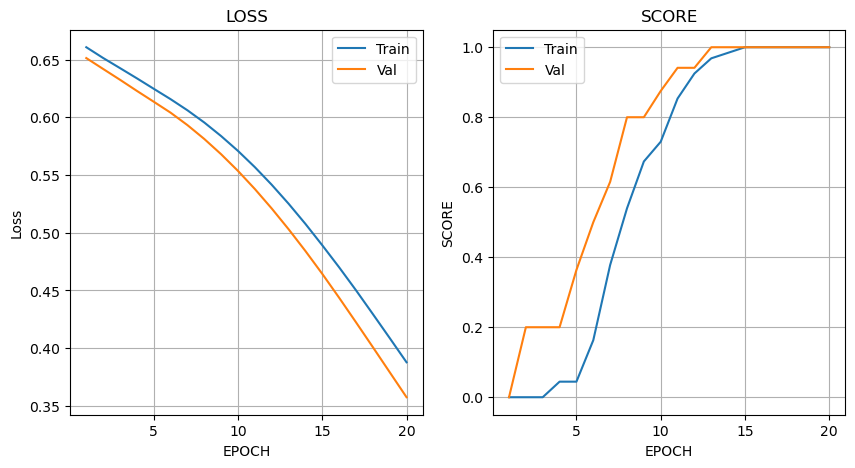

In [20]:
# 학습 후 LOSS 시각화
TH = len(LOSS_HISTORY[0])
fg, axes = plt.subplots(1,2, figsize=(10,5), sharex=True)

axes[0].plot(range(1,TH+1),LOSS_HISTORY[0][:TH], label='Train')
axes[0].plot(range(1,TH+1),LOSS_HISTORY[1][:TH], label='Val')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,TH+1),SCORE_HISTORY[0][:TH], label='Train')
axes[1].plot(range(1,TH+1),SCORE_HISTORY[1][:TH], label='Val')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('SCORE')
axes[1].set_title('SCORE')
plt.show()